In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# %pip install --upgrade tensorflow
# %pip install keras==2.12.0
# %pip install --upgrade joblib
# %pip install scikeras

In [3]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from sklearn.model_selection import GridSearchCV
from keras.utils import to_categorical
from tensorflow import keras
import pywt
from sklearn.preprocessing import StandardScaler


In [4]:
# ------------------------------ Train Data ------------------------------ #

In [6]:
def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def load_data_by_task(data_folder):
    meg_data_list = []
    labels = []

    for file in os.listdir(data_folder):
        if file.endswith('.h5'):
            file_path = os.path.join(data_folder, file)
            data = load_data(file_path)
            if data is not None:
                meg_data_list.append(data)
                label = assign_label(file)
                labels.append(label)

    if meg_data_list:
        meg_data_array = np.stack(meg_data_list, axis=0)
        labels_array = np.array(labels)
        return meg_data_array, labels_array
    else:
        return None, None

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 0
    elif file_name.startswith("task_motor"):
        return 1
    elif file_name.startswith("task_story"):
        return 2
    elif file_name.startswith("task_working"):
        return 3
    else:
        return None

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/train')
    raise Exception("meg_data folder not found. Please check the directory structure.")


def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y



def apply_scaling(array):
  array_norm = np.zeros((array.shape[0],array.shape[1],array.shape[2]))
  for i in range(array.shape[0]):
    means = np.mean(array[i], axis=1)  # Calculate mean for each sensor
    stds = np.std(array[i], axis=1)    # Calculate standard deviation for each sensor
    array_norm[i] = (array[i] - means[:, np.newaxis]) / stds[:, np.newaxis]   # Subtrack and divide

  del array, means, stds
  gc.collect()
  return array_norm


def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 4
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros_like(array)

  for o in range(array.shape[0]):
      for i in range(array.shape[1]):
          array_filtered[o, i, :] = butter_lowpass_filter(array[o, i, :], cutoff_frequency, original_sampling_rate)

  del array
  return array_filtered


def apply_downsampling(array):
  n_observations, n_sensors, n_timepoints = array.shape
  new_n_timepoints = n_timepoints // 4
  downsampling_factor = 4
  array_downsamp = np.zeros((n_observations, n_sensors, new_n_timepoints))

  for obs in range(n_observations):
    for sensor in range(n_sensors):
      array_downsamp[obs,sensor,:] = array[obs, sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_observations, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp




def apply_wavelet_transform(data, wavelet='db4', level=5, original_length=8906):
    transformed_data = np.zeros(data.shape)  # Initialize array to maintain original shape

    for i in range(data.shape[0]):  # Loop over observations
        for j in range(data.shape[1]):  # Loop over sensors
            # Apply wavelet transform to the sensor's data
            coeffs = pywt.wavedec(data[i, j, :], wavelet, level=level)
            # Concatenate and pad the coefficients to match original length
            concatenated_coeffs = np.concatenate(coeffs)
            pad_length = original_length - concatenated_coeffs.shape[0]
            if pad_length > 0:
                concatenated_coeffs = np.pad(concatenated_coeffs, (0, pad_length), 'constant')
            else:
                concatenated_coeffs = concatenated_coeffs[:original_length]
            # Assign the transformed data
            transformed_data[i, j, :] = concatenated_coeffs

    return transformed_data


fmri_data_folder = find_fmri_data_folder('/content/drive/My Drive')

tasks = ['rest', 'task_motor', 'task_story', 'task_working']
task_numbers = ['_1.','_2.','_3.','_4.','_5.','_6.','_7.','_8.']
visual_data = []

X_task, y_task = load_data_by_task(fmri_data_folder)



In [7]:
if X_task is not None and y_task is not None:
    print("Train shape:", X_task.shape)
    print("Labels shape:", y_task.shape)

    ##########
    visual_data.append(X_task[0,0])

    # Scaling
    X_task_norm = apply_scaling(X_task)
    print("X_task_norm", X_task_norm.shape)
    del X_task
    gc.collect()
    ##########
    visual_data.append(X_task_norm[0,0])

    # Lowpass filter
    X_task_filtered = apply_lowpass(X_task_norm)
    print("X_task_filtered", X_task_filtered.shape)
    del X_task_norm
    gc.collect()
    ##########
    visual_data.append(X_task_filtered[0,0])

    # Downsample
    X_task_downsamp = apply_downsampling(X_task_filtered)
    print("X_task_downsamp", X_task_downsamp.shape)
    del X_task_filtered
    gc.collect()
    ##########
    visual_data.append(X_task_downsamp[0,0])

    print("After downsampling:", X_task_downsamp.shape)

    # Create wavelets
    # Apply Wavelet Transform
    X_task_wavelet = apply_wavelet_transform(X_task_downsamp)
    print("X_task_wavelet", X_task_wavelet.shape)
    del X_task_downsamp
    #########
    visual_data.append(X_task_wavelet[0,0])

    # ----- Train the model on this task's data ----- #
    obs_train, sensors_train, points_train = X_task_wavelet.shape

    X_train = X_task_wavelet.reshape(obs_train, sensors_train, points_train, 1)
    print("X_train shape:", X_train.shape)

    y_train_encoded = to_categorical(y_task, num_classes=4)

    del y_task, obs_train, X_task_wavelet, visual_data
    gc.collect()

Train shape: (32, 248, 35624)
Labels shape: (32,)
X_task_norm (32, 248, 35624)
X_task_filtered (32, 248, 35624)
X_task_downsamp (32, 248, 8906)
After downsampling: (32, 248, 8906)
X_task_wavelet (32, 248, 8906)
X_train shape: (32, 248, 8906, 1)


In [8]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), strides=(2, 2), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [10]:
model = build_cnn_model(input_shape=(248,8906,1), num_classes=4)


history = model.fit(X_train, y_train_encoded, epochs=12, batch_size=32)
# Clear memory
# del X_train, y_train_encoded,
gc.collect()

Epoch 1/12
1/1 [==============================] - 13s 13s/step - loss: 1.4215 - accuracy: 0.2500
Epoch 2/12
1/1 [==============================] - 10s 10s/step - loss: 6.9207 - accuracy: 0.2500
Epoch 3/12
1/1 [==============================] - 11s 11s/step - loss: 4.2439 - accuracy: 0.2500
Epoch 4/12
1/1 [==============================] - 8s 8s/step - loss: 1.9975 - accuracy: 0.2500
Epoch 5/12
1/1 [==============================] - 11s 11s/step - loss: 1.2053 - accuracy: 0.7500
Epoch 6/12
1/1 [==============================] - 10s 10s/step - loss: 0.7805 - accuracy: 0.5938
Epoch 7/12
1/1 [==============================] - 10s 10s/step - loss: 0.7911 - accuracy: 0.7812
Epoch 8/12
1/1 [==============================] - 11s 11s/step - loss: 0.4414 - accuracy: 1.0000
Epoch 9/12
1/1 [==============================] - 8s 8s/step - loss: 0.3681 - accuracy: 0.9688
Epoch 10/12
1/1 [==============================] - 12s 12s/step - loss: 0.2372 - accuracy: 1.0000
Epoch 11/12
1/1 [================

651

Text(0, 0.5, 'Amplitude')

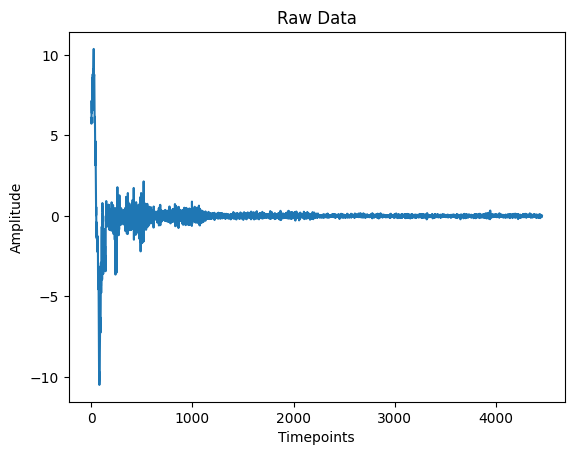

In [16]:
import matplotlib.pyplot as plt

# Assuming each array is a NumPy array and the first sensor's data is the first row
# Example: raw_data[0, :], scaled_data[0, :], etc.


# Plot Raw Data
plt.plot(X_train.reshape(32,248,4453)[0,233], label='Raw Data')
plt.title('Raw Data')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')

In [ ]:
# ------------------------------ Test data ------------------------------ #

In [16]:
# Retrieve Test data

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/test')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 0
    elif file_name.startswith("task_motor"):
        return 1
    elif file_name.startswith("task_story"):
        return 2
    elif file_name.startswith("task_working"):
        return 3
    else:
        return None

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

fmri_data_folder = find_fmri_data_folder('/content/drive/My Drive')
meg_test_data_list = []
labels_test = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_test_data_list.append(data)
        labels_test.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_test_data_array = np.stack(meg_test_data_list, axis=0)
labels_test_array = np.array(labels_test)



def apply_scaling(array):
  array_norm = np.zeros((array.shape[0],array.shape[1],array.shape[2]))
  for i in range(array.shape[0]):
    means = np.mean(array[i], axis=1)  # Calculate mean for each sensor
    stds = np.std(array[i], axis=1)    # Calculate standard deviation for each sensor
    array_norm[i] = (array[i] - means[:, np.newaxis]) / stds[:, np.newaxis]   # Subtrack and divide

  del array, means, stds
  gc.collect()
  return array_norm

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 4
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros_like(array)

  for o in range(array.shape[0]):
      for i in range(array.shape[1]):
          array_filtered[o, i, :] = butter_lowpass_filter(array[o, i, :], cutoff_frequency, original_sampling_rate)

  del array
  return array_filtered


  del array
  gc.collect()
  return array_filtered


def apply_downsampling(array):
  n_observations, n_sensors, n_timepoints = array.shape
  new_n_timepoints = n_timepoints // 4
  downsampling_factor = 4
  array_downsamp = np.zeros((n_observations, n_sensors, new_n_timepoints))

  for obs in range(n_observations):
    for sensor in range(n_sensors):
      array_downsamp[obs,sensor,:] = array[obs, sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_observations, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp


def apply_wavelet_transform(data, wavelet='db4', level=5, original_length=8906):
    transformed_data = np.zeros(data.shape)  # Initialize array to maintain original shape

    for i in range(data.shape[0]):  # Loop over observations
        for j in range(data.shape[1]):  # Loop over sensors
            # Apply wavelet transform to the sensor's data
            coeffs = pywt.wavedec(data[i, j, :], wavelet, level=level)
            # Concatenate and pad the coefficients to match original length
            concatenated_coeffs = np.concatenate(coeffs)
            pad_length = original_length - concatenated_coeffs.shape[0]
            if pad_length > 0:
                concatenated_coeffs = np.pad(concatenated_coeffs, (0, pad_length), 'constant')
            else:
                concatenated_coeffs = concatenated_coeffs[:original_length]
            # Assign the transformed data
            transformed_data[i, j, :] = concatenated_coeffs

    return transformed_data


X_task_norm = apply_scaling(meg_test_data_array)
del meg_test_data_array
gc.collect()

# Lowpass filter
X_task_filtered = apply_lowpass(X_task_norm)
del X_task_norm
gc.collect()

# Downsample
X_task_downsamp = apply_downsampling(X_task_filtered)
del X_task_filtered
gc.collect()

# Create wavelets
# Apply Wavelet Transform
X_test_wavelet = apply_wavelet_transform(X_task_downsamp)
del X_task_downsamp


obs_test, sensors_test, points_test = X_test_wavelet.shape
X_test = X_test_wavelet.reshape(obs_test, sensors_test, points_test, 1)
y_test_encoded = to_categorical(labels_test_array, num_classes=4)

In [17]:
X_test.shape

(8, 248, 8906, 1)

In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)

1/1 [==============================] - 1s 873ms/step - loss: 1.3626 - accuracy: 0.3750


In [19]:
# TEST DNN

X_test_dnn = X_test.reshape(8, -1)  # Flatten the test data for DNN
test_loss_dnn, test_accuracy_dnn = model.evaluate(X_test, y_test_encoded)
print("DNN Test Loss:", test_loss_dnn)
print("DNN Test Accuracy:", test_accuracy_dnn)


1/1 [==============================] - 1s 737ms/step - loss: 1.3626 - accuracy: 0.3750
DNN Test Loss: 1.3625785112380981
DNN Test Accuracy: 0.375


In [20]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

# Convert predictions and true labels to single labels if they are one-hot encoded
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_encoded, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

1/1 [==============================] - 1s 1s/step


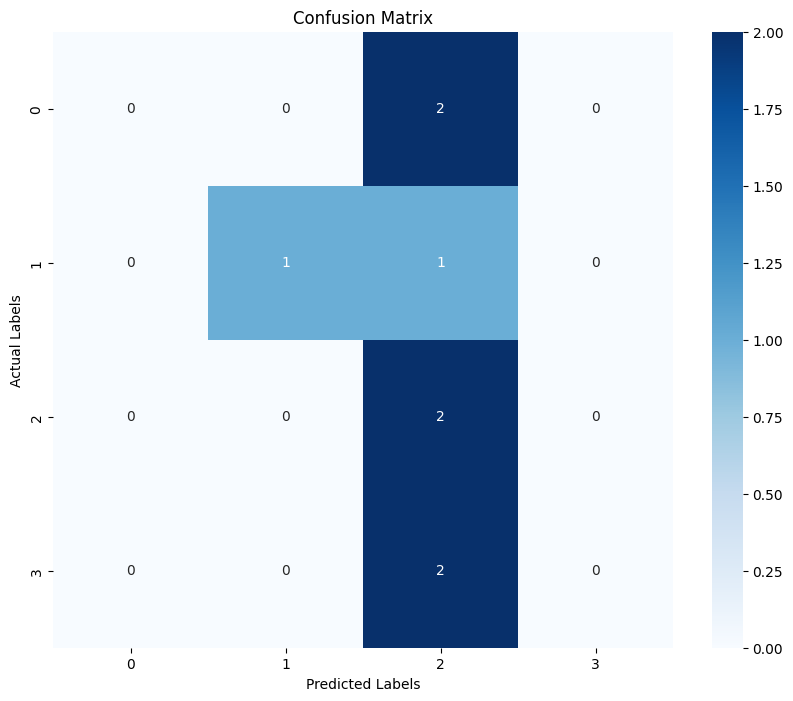

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [ ]:
import numpy as np

# Make predictions for the entire test set. They are in one-hot-vector form.
all_predictions = model.predict(X_test)

# Convert predictions to class labels (0, 1, 2, 3)
predicted_labels_all = np.argmax(all_predictions, axis=1)

# Aggregate predictions for each original test instance
# For every 248 predictions keep the most frequent one (that represents the each total file's prediction)
final_predictions = []
proportions = []
for i in range(0, len(predicted_labels_all), 248):  # Iterate over each set of 248 sensors (step=248)
    # Get the predictions for the current set of sensors
    sensor_predictions = predicted_labels_all[i:i + 248]
    print(sensor_predictions)

    unique, counts = np.unique(sensor_predictions, return_counts=True)
    print("\n",dict(zip(unique, counts)))

    # Find the most frequent prediction
    most_frequent_prediction = np.argmax(np.bincount(sensor_predictions))
    print("MOST FREQUENT:", most_frequent_prediction)

    # Find the proportion of this prediction compared to all the other labels
    proportion = np.max(np.bincount(sensor_predictions)) / 248
    print(f"PROPORTION: {(proportion*100):.2f}%")
    proportions.append(proportion)

    print("_____________________________________________________________________________________________")
    final_predictions.append(most_frequent_prediction)

62/62 [==============================] - 8s 122ms/step
[1 2 1 3 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 3 2 3 2 1 1 1 1 3 2 3 3 1
 3 1 1 1 1 1 0 1 1 1 3 1 1 2 3 1 2 1 1 1 3 1 3 1 2 3 1 3 1 3 1 3 1 2 3 1 1
 1 3 0 1 1 0 1 1 3 0 1 2 0 2 2 2 2 1 2 1 2 3 2 2 2 1 1 1 1 1 1 3 3 1 3 1 0
 1 1 0 1 1 1 1 1 1 1 2 0 2 1 2 1 2 2 1 3 1 2 3 1 1 1 3 1 3 2 2 3 0 1 0 0 1
 3 1 0 2 1 1 2 1 2 2 1 3 2 2 3 2 3 2 2 1 2 1 1 2 1 3 1 3 2 3 1 1 3 1 0 1 0
 1 0 2 1 1 2 2 3 2 1 2 2 1 3 2 1 1 1 1 1 2 3 1 3 0 1 1 0 1 1 1 1 1 0 2 0 2
 1 1 2 1 1 3 1 1 2 2 2 2 2 1 0 1 1 3 1 3 1 0 1 1 1 1]

 {0: 21, 1: 129, 2: 56, 3: 42}
MOST FREQUENT: 1
PROPORTION: 52.02%
_____________________________________________________________________________________________
[3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 0 3 3 0 3 0 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 0 3 3 3 3 0 3 3 3 3 3 0 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 3 0 3 0 3 3 3 3 3 0 3 3 3 3 3 0 3 3 3 3 3
 3 3 3 3 3 3 0 3 3 3 3 3 3 2 3 3 0 3 3 3 0 3 3 3 3 3 3

In [ ]:
print("FINAL PREDICTIONS (TOP), ACTUAL LABELS (BOTTOM)")
print(final_predictions)
print(list(labels_test_array))
print()
# Calculate accuracy or other metrics if needed
correct_predictions = np.sum(np.array(final_predictions) == labels_test_array)
accuracy = correct_predictions / len(final_predictions)
print("Aggregated Accuracy:", accuracy)

FINAL PREDICTIONS (TOP), ACTUAL LABELS (BOTTOM)
[1, 3, 2, 1, 1, 1, 1, 0]
[1, 3, 2, 2, 1, 0, 3, 0]

Aggregated Accuracy: 0.625


In [ ]:
# Print individual comparisons
for i in range(len(labels_test_array)):
    print(f"File {i}: Actual Label = {labels_test_array[i]}, Aggregated Predicted Label = {final_predictions[i]}")

File 0: Actual Label = 1, Aggregated Predicted Label = 1
File 1: Actual Label = 3, Aggregated Predicted Label = 3
File 2: Actual Label = 2, Aggregated Predicted Label = 2
File 3: Actual Label = 2, Aggregated Predicted Label = 1
File 4: Actual Label = 1, Aggregated Predicted Label = 1
File 5: Actual Label = 0, Aggregated Predicted Label = 1
File 6: Actual Label = 3, Aggregated Predicted Label = 1
File 7: Actual Label = 0, Aggregated Predicted Label = 0


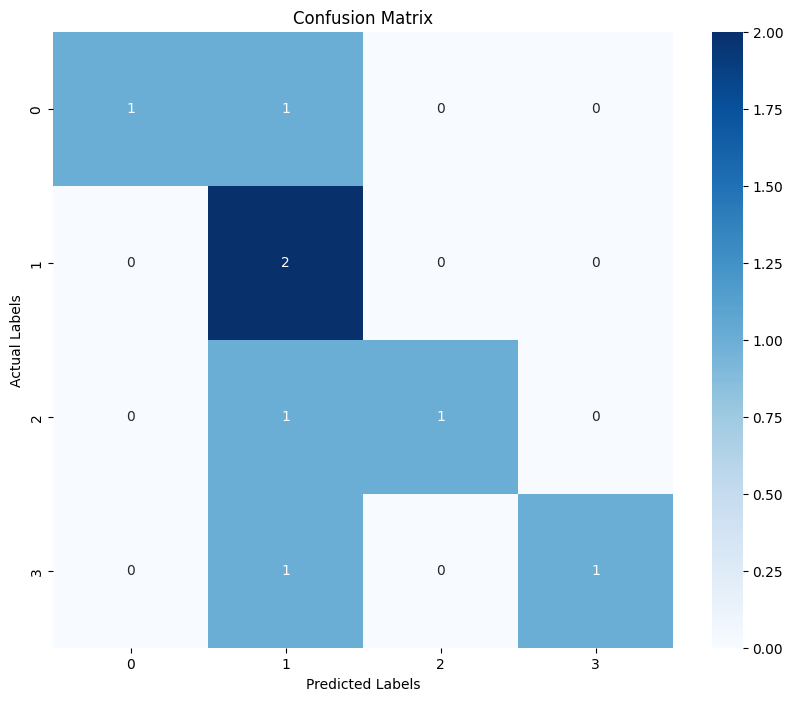

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(labels_test_array, final_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()
